In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.animation as anim

# <center> Partial differential equations and Physics - Part I </center>

In this notes, we shall learn how to relax! These are a set of numerical techniques for solving elliptic-type PDE's, which is a class of differential equations where there is no sense of information propagation. One cannot 'integrate in' from the boundary conditions, in contrast to parabolic- and hyperbolic-type equations, which may be trated as an initial value problem.

In relaxation techniques, one essentially recasts the elliptic problem in a related parabolic-type PDE. In this way, we may use techniques we've already developed for initial value-type problems to elliptic PDE's. When we encounter an equilibrium state, this will turn out to be a solution of the original elliptic-type PDE.

## <center> Classification of PDE's </center>

We have been referring to different types of PDE's. Here we shall try to ground their definition more firmly. As we shall see, their naming convention indeed comes from conic section, but their physical content is very different.

Consider the following general form of a second-order PDE,
\begin{equation}
A \partial_x^2 \psi + B \partial_t\partial_x \psi + C \partial_t^2 \psi + D \partial_x \psi + E \partial_t \psi + F \psi + G = 0
\end{equation}
Let us analogize this equation to conic sections,
\begin{equation}
A x^2 + B xy + C y^2 + D x + E y + F = 0.
\end{equation}
That is, let us classify second-order PDE's using the discriminant of conic section,
\begin{equation}
B^2 - 4AC \to \left\lbrace
\begin{matrix}
> 0, & hyperbola \\
= 0, & parabola \\
< 0, & ellipse
\end{matrix}
\right.
\end{equation}
But is there any use for such a classification of second-order linear PDE's? The answer lies in the existence of characteristic curves. These are defined to be curves, say $x(t)$, such that the above second-order linear PDE reduces to a first-order PDE. That is, let us suppose
\begin{equation}
\psi(x,t) = \psi(x(t),t)
\end{equation}
is a solution. Then a sufficient condition for the second order derivatives to disappear is gleaned from
\begin{equation}
A \partial_x^2 \psi + B \partial_t\partial_x \psi + C \partial_t^2 \psi = \left( A \left(\dfrac{\partial x}{\partial t}\right)^{-2} + B \left( \dfrac{\partial x}{\partial t} \right)^{-1} + C \right) \partial_t^2 \psi
\end{equation}
This yields the condition,
\begin{equation}
\left( \dfrac{\partial x}{\partial t} \right)^{-1} = \dfrac{-B \pm \sqrt{B^2 - 4AC}}{2A}
\end{equation}
for the characteristic curves. This gives us a better understanding for the usefulness of the classification of PDE's under the auspices of 'hyperbolic', 'parabolic' and 'elliptic', and also points a way of extending this definition to higher order and higher dimensional PDE's: hyperbolic-type equations have purely real characteristic curves, parabolic-type equations have a lower number of characteristic curves as there are dimensions, while elliptic-type equations have complex characteristic curves.

These characteristic curves describe information transport. Because hyperbolic-type and parabolic-type equations have real characteristic curves, one may treat them as an initial value problem (and the number of characteristic curves also define how much initial information is needed to start a unique evolution), while the same is impossible for elliptic-type equations. Any perturbation is instantly communicated everywhere.

The model elliptic-type PDE is the Poisson equation.

## <center> The direct method </center>

We have already solved the Poisson equation via the direct method. To refresh our memory, consider the Poison equation in 1-dimension,
\begin{equation}
\dfrac{\partial^2 u}{\partial x^2} = f(x), \qquad 0 < x <1, \qquad u(0) = a, u(1) = b.
\end{equation}
A straightfoward numerical method to solve this is to define an equally-spaced (n+1)-point mesh, defined by,
\begin{equation}
x_j = \dfrac{j}{n}, \qquad u_j = u(x_j), \qquad f_j = f(x_j),
\end{equation}
and utilize the second-order discretization,
\begin{equation}
\dfrac{u_{j-1} - 2 u_j + u_{j+1}}{h^2} = \left. \dfrac{\partial^2 u}{\partial x^2} \right|_{x_j} + O(h^2).
\end{equation}
We obtain a set of algebraic equations for the set of function values $u_j$,
\begin{equation}
\dfrac{u_{j-1} - 2 u_j + u_{j+1}}{h^2} = f_j, \qquad j=1,2,\dots,n-1
\end{equation}
Note that $j = 1, n-1$ are explicitly
\begin{equation}
\dfrac{- 2 u_1 + u_{2}}{h^2} = f_1 - \dfrac{a}{h^2}, \qquad \dfrac{u_{n-2} - 2 u_{n-1}}{h^2} = f_{n-1} - \dfrac{b}{h^2}.
\end{equation}
Thius yields a tridiagonal linear system of equations of the form,
\begin{equation}
\textbf{A} \textbf{u} = \textbf{F}
\end{equation}
where $\textbf{u} = (u_1, u_2, \dots, u_{n-1})^T$ and
\begin{equation}
A_{ij} = \dfrac{1}{h^2} \left(\delta_{i,j+1} -2\delta_{i,j} + \delta_{i,j-1} \right), \qquad F_i = f_i - \dfrac{a}{h^2} \delta_{i,1} - \dfrac{b}{h^2} \delta_{i,n-1}.
\end{equation}
The form of the solution, we had already derived in Notes 5: $\textbf{u} = \textbf{A}^{-1} \textbf{F}$. The question now is how does one invert $\textbf{A}$?

___

Large sparse matrices, such as the one we have derived, pop-up in physics all the time. Accordingly, many methods have been developed to invert them. This gives us the promise that with enough time and computing power, we can directly solve an elliptic-type PDE. However, there are some limitations that might prevent us from implementing a 'direct solver':

1. **Scalability**. Consider the naive implementation where we use Gauss-Jordan elimination to solve for $\textbf{A}^{-1}$, which has a computational complexity of $O(n^3)$. Suppose we increase the number of dimensions of our Poisson equation by 1, with
\begin{equation}
\dfrac{\partial^2 u}{\partial x^2} + \dfrac{\partial^2 u}{\partial y^2} = f(x,y), \qquad 0 < x <1, \; \; 0 < y < 1
\end{equation}
and Dirichlet boundary conditions. If we define an equally spaced mesh,
\begin{equation}
\textbf{x}_{i,j} = (x_i,y_j) = \left( \dfrac{i}{n}, \dfrac{j}{n} \right), \qquad u_{i,j} = u(\textbf{x}_{i,j}), \qquad f_{i,j} = f(\textbf{x}_{i,j})
\end{equation}
the number of unknowns balloons from $\sim n$ to $\sim n^2$, and the computational complexity of inverting the corresponding $\textbf{A}$ goes from $O(n^3) \to O(n^6)$. The amount of computer memory also needed gets high really fast. For example, the size of $\textbf{A}$ goes from $\sim n^2$ to $\sim n^4$.
2. **Generality**. Fast algorithms for inverting large sparse matrices keenly rely on certain symmetries the matrix to be inverted must possess, such as $\textbf{A}$ being positive definite, symmetric, Hermitian, or, in this case, trdiagonal. Is there an easy way to determine what type of discretization scheme must be used so that the resulting $\textbf{A}$ has these symmetries, just by looking at the form of the PDE? In most cases: **no**. Even moving the Posson equation to 2 dimensions spoils the tridiagonal property, with
\begin{equation}
\dfrac{u_{i-1,j} - 2 u_{i,j} + u_{i+1,j}}{h^2} + \dfrac{u_{i,j-1} - 2u_{i,j} + u_{i,j+1}}{h^2}  = f_{i,j}, \qquad i=1,2,\dots,n-1, \;\; j = 1,2,\dots,n-1
\end{equation}
Let us assume our solution vanishes at the boundaries, for simplicity. There is an ambiguity here how one might arrange the unknowns $u_{i,j}$ into a column vector, and in general there usually isn't any a priori reason to favour one ordering over another. Although ordering should not make any real difference, sometimes symmetries are easier to identify in particular orderings, which would inform how a faster direct method may be implemented.
For now, consider a **lexicographic ordering** by lines of constant j (otherwise known as a natural row-wise ordering). That is, one may write down the above set of linear algebraic equations into a linear block tridiagonal matrix equation of the form,
\begin{equation}
\tilde{\textbf{A}} \tilde{\textbf{u}} = \tilde{\textbf{F}}
\end{equation}
where $\tilde{\textbf{u}} = (\textbf{u}_1, \textbf{u}_2, \dots, \textbf{u}_{n-1})^T$ and $\textbf{u}_j = (u_{1,j}, u_{2,j} \dots, u_{n-1,j})$, and
\begin{equation}
\tilde{\textbf{A}} = \dfrac{1}{h^2}
\begin{pmatrix}
\textbf{T} & \textbf{I} \\
\textbf{I} & \textbf{T} & \textbf{I}  \\
& \textbf{I} & \textbf{T} & \textbf{I}\\
& & \ddots & \ddots & \ddots \\
& & & \textbf{I} & \textbf{T} & \textbf{I} \\
& & & & \textbf{T} & \textbf{}
\end{pmatrix}
\end{equation}
and
\begin{equation}
T_{i,j} = \delta_{i,j+1} - 4 \delta_{i,j} + \delta_{i,j-1}, \qquad I_{ij} = \delta_{i,j},
\end{equation}
\begin{equation}
\tilde{\textbf{F}} = (\textbf{F}_1,\textbf{F}_2,\dots,\textbf{F}_{n-1})^T, \qquad \textbf{F}_j = (f_{1,j},f_{2,j},\dots,f_{n-1,j}).
\end{equation}
That is, in 2-dimensions, we go from being tri-diagonal to being block tri-diagonal.
3. **Stability**.  One might think that because of an algorithm like Cramer's rule or Gauss-Jordan elimination, one is always assured to get the correct inverse of A in a finite number of arithmetic operations. However, this might be spoiled by the finite precision of computer arithmetic. How many computer arithmetic operations would it take for accumulated errors to become significant?
	 
Of course there are methods that address these issues. On the other hand, their implementation is not as straightforward as simply pivoting towards relaxation methods.

## <center> Elliptic-type PDE to parabolic-type PDE </center>

We begin with the following observation: notice that the heat equation,
\begin{equation}
\dfrac{\partial u}{\partial t} - \alpha \dfrac{\partial^2 u}{\partial x^2} = g(x)
\end{equation}
reduces to the Poisson equation at equilibrium ($\partial_t u = 0$), provided we make the identification $\alpha = 1$ and $g(x) = -f(x)$. This motivates the following method:
1. Start with an initial guess $u(x,0)$.
2. Evolve this initial data using a discretization of the heat equation.
3. Once the evolution is *sufficiently* at equilibrium, terminate.

We have already discussed a method to integrate the heat equation in Notes 12: the method of lines. That is, we discretize the heat equation in space,
\begin{equation}
\partial_t u_i(t) = \dfrac{ u_{i-1}(t) - 2 u_i(t) + u_{i+1}(t) }{h_x^2} -f_i
\end{equation}
which is now amenable to the use of ODE methods. Let us consider an Euler method to integrate through time. We'd get
\begin{equation}
u_i(t+h_t) = u_i(t) - h_t f_i + \dfrac{h_t}{h_x^2} \left( u_{i-1}(t) - 2 u_i(t) + u_{i+1}(t) \right)
\end{equation}
This is just the forward-in-time, central-in-space (FTCS) discretization. One might wonder why we it is standard practice to solve parabolic-type equations using a first-order discretization in time and second-order in space. It might seem odd why we have not chosen a second-order discretization in time. We shall explain this in a bit.
___
Not all values for the pair $(h_t, h_x)$ is stable. Using von Neumann analysis (Chapter 9.3.2 [CP]), they must meet the condition
\begin{equation}
\dfrac{h_t}{h_x^2} \leq \dfrac{1}{2}
\end{equation}
This condition has a natural physical explanation: the maximum step $h_t$ must be less than or equal to the diffusion time across a distance $h_x$. Hitting against this maximum gives us the most efficient update scheme,
\begin{equation}
u_i(t + h^2/2) = \dfrac{u_{i-1}(t) + u_{i+1}(t) - h^2 f_i}{2}
\end{equation}
This justifies our use of a FTCS discretization, since our choice for $h_t$ and $h_x$ yields the same order of magnitude of the local error.

Notice that our integration step size is not $h^2/2$. This tells us that integration proceeds very slowly. Using a higher-order time-integration scheme would let us integrate things faster, but analysing what pairs of $(h_t,h_x)$ are stable via von Neumann analysis becomes more complicated as you increase the accuracy of the discretization.

## <center> Jacobi relaxation - the method of simultaneous displacements </center>

Instead of treating
\begin{equation}
\dfrac{u_{j-1} - 2 u_j + u_{j+1}}{h^2} = f_j, \qquad j=1,2,\dots,n-1
\end{equation}
as a matrix inversion problem, let us treat it as a multi-dimensional root finding problem. For each algebraic equation given above, we may implement either Newton-Raphson or relaxation to iteratively solve for $u_j$ given some initial guess. We'd get,
\begin{equation}
u^{i+1}_j = \dfrac{u^i_{j-1} + u^i_{j+1} - h^2 f_i}{2}.
\end{equation}
Surprisingly, this is the same equation we got by relating the original elliptic-type PDE to a related parabolic-type PDE, using a first-order in time and second-order in space discretization to evolve it, and using von Neumann analysis to get the most efficient evolution scheme towards equilibrium.

All of those steps, encapsulated by just treating the elliptic discretization as a root finding problem! This is the advantage of relaxation methods: they are generally efficient in some way. If you used the parabolic-type PDE with a fourth-order discretization in space, what should be your time discretization? What is the most efficient way to evolve that system in time, given a spatial discretization $h_x$? Apparently, one may instead discretize the elliptic-type PDE to fourth order, and just use relaxation to get the most efficient evolution scheme, no additional math required.

Of course, the trade-off is that the evolution is now more opaque. What is the abstract time-like space indexed by $i$, and how fast are we evolving through it? How can we determine the stability of the method?

### <center> Model problem </center>

We use the model problem we introduced in Notes 5. That is,
\begin{equation}
f(x) = 2 \pi \cos(\pi x^2) - 4 \pi^2 x^2 \sin(\pi x^2), \qquad u(0) = u(1) = 0.
\end{equation}
The exact solution is given by
\begin{equation}
u(x) = \sin(\pi x^2).
\end{equation}

In [2]:
def RelJac(u, f, h):
    """
    Solves the Poisson equation using the method of simultaneous displacements.
    Assume Dirichlet boundary conditions
    """
    
    ###calculate interior points
    unew = 0.5 * ( u[2:] + u[:-2] - h**2 * f[1:-1])
    
    ### return boundary points
    unew = np.insert(unew,0,u[0])
    unew = np.append(unew,u[-1])
    return unew

def RelEvolve(u, f, h, relmethod):
    while True:
        yield u
        u = RelJac(u, f, h)

N = 65
h = 1/(N-1)
x = np.linspace(0,1,N)
f = 2 * np.pi * np.cos( np.pi * x**2) - 4 * np.pi**2 * x**2 * np.sin( np.pi * x **2)

        
## let us generate a random initial guess that satisfies the boundary conditions u(0) = u(1) = 0
u = np.random.random(N)
u[0] = 0
u[-1] = 0

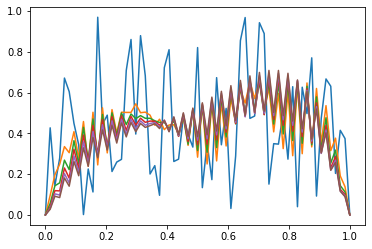

In [3]:
plt.plot(x,u)
evolution = RelEvolve(u, f, h, RelJac)
skip = 10
frames = 5
for _ in range(frames):
    for _ in range(skip):
        u = next(evolution)
    plt.plot(x,u)

Several key features:
1. **There is a splitting between odd and even nodes.** This comes from a combination of the PDE and discretization we used. The result is that odd nodes are dependent only on even nodes, and vice versa. This is the basis of so-called 'red-black' algorithms, which color points on the mesh differently based on these types of separations.
2. **High-frequency errors are quickly damped out, while smoother errors are more long-lived.** This may easily be understood from a Fourier-transform perspective: the time scale for a certain mode with frequency $\omega$ is $\omega^2$ (recall Notes 9). This is a generic property of relaxation methods on second-order PDE's, since high-frequency modes of the error locally reduces to the heat equation. (That is, the second derivatives dominate).

Let us now animate.

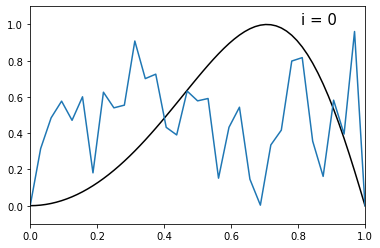

In [4]:
fig = plt.figure()
ax = plt.axes(xlim = (0,1), ylim = (-0.1,1.1))
plt.rcParams.update({'font.size': 15})
time_text = ax.text(0.81, 1, '')
exact, = ax.plot(x,np.sin(np.pi * x **2), color= 'black')
sol, = ax.plot([],[])

N = 33
h = 1/(N-1)
x = np.linspace(0,1,N)
f = 2 * np.pi * np.cos( np.pi * x**2) - 4 * np.pi**2 * x**2 * np.sin( np.pi * x **2)

        
## let us generate a random initial guess that satisfies the boundary conditions u(0) = u(1) = 0
u = np.random.random(N)
u[0] = 0
u[-1] = 0
evolution = RelEvolve(u, f, h, RelJac)

def get_plot(data_gen, skip):
    def plot(n):
        u = next(data_gen)
        sol.set_data(x, u)
        time_text.set_text('i = {0}'.format(n))
        for _ in range(skip - 1):
            u = next(data_gen)
        return (sol,time_text)
    return plot

plot_func = get_plot(evolution, 1)

ani = anim.FuncAnimation(fig, plot_func, frames = 500, interval = 50, blit = True)

In [5]:
HTML(ani.to_html5_video())

## <center> Gauss-Seidel method - the method of successive displacements </center>

Let's say we were trying to solve a massive problem, and we are quickly running out of memory. In a desperate attempt to find space, say we no longer store two separate frames in our update scheme. Instead, as we sweep across our mesh, we immediately store the updated value onto our current mesh. This updated value would then be used by other unupdated mesh points during their update. A method of successive displacements, if you will.

This is the Gauss-Seidel method. For the Poisson equation, with an update that sweeps from left to right, the update scheme would look like,
\begin{equation}
u^{i+1}_{j} = \dfrac{u^{i+1}_{j-1} + u^i_{j+1} - h^2 f_i}{2}.
\end{equation}
This isn't easy to implement using vectorization, so our speed as Python users would take a big hit. However, this method is actually faster than the Jacobi method (and generally more stable) if we somehow are able to compile the code.

In [6]:
def RelGS(u, f, h):
    """
    Solves the Poisson equation using the method of successive displacements.
    Assume Dirichlet boundary conditions
    """
    N = u.shape[0]
    for i in range(1,N-1):
        u[i] = 0.5 * (u[i-1] + u[i+1] - h**2 * f[i])
        

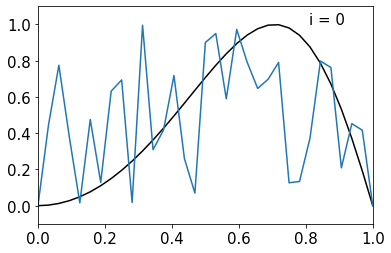

In [7]:
fig = plt.figure()
ax = plt.axes(xlim = (0,1), ylim = (-0.1,1.1))
plt.rcParams.update({'font.size': 15})
time_text = ax.text(0.81, 1, '')
exact, = ax.plot(x,np.sin(np.pi * x **2), color= 'black')
sol, = ax.plot([],[])

N = 33
h = 1/(N-1)
x = np.linspace(0,1,N)
f = 2 * np.pi * np.cos( np.pi * x**2) - 4 * np.pi**2 * x**2 * np.sin( np.pi * x **2)

        
## let us generate a random initial guess that satisfies the boundary conditions u(0) = u(1) = 0
u = np.random.random(N)
u[0] = 0
u[-1] = 0
evolution = RelEvolve(u, f, h, RelGS)

def get_plot(data_gen, skip):
    def plot(n):
        u = next(data_gen)
        sol.set_data(x, u)
        time_text.set_text('i = {0}'.format(n))
        for _ in range(skip - 1):
            u = next(data_gen)
        return (sol,time_text)
    return plot

plot_func = get_plot(evolution, 1)

ani = anim.FuncAnimation(fig, plot_func, frames = 500, interval = 50, blit = True)

In [8]:
HTML(ani.to_html5_video())

## <center> Under- and over-relaxation </center>

We now apply one last technique, which is something that is used in root finding algorithms: under- and over-relaxation. Underrelaxation slows down the speed at which our method approaches a root, in the interest of stability. Overrelaxation speeds up how long we approach a root, at the cost of stability. 

Both methods simply modify our update scheme by using a weighted average of the pre-update and post-update values. That is, for some parameter $\omega$, we use the approximation
\begin{equation}
\tilde{u}_j^{i+1} \approx (1-\omega) u^i_j + \omega u^{i+1}_j
\end{equation}
What is the optimal value of $\omega$, for the Poisson equation? Apparently, it is
\begin{equation}
\omega = \dfrac{2}{1 + \sinh \pi h} \approx 2 - 2 \pi h
\end{equation}
The derivation of this is beyond the scope of this notes. However, we shall be discussing the tools at which $\omega$ may be derived when we finally discuss matrix splitting.

In [9]:
def RelSOR(u, f, h):
    """
    Solves the Poisson equation using the method of successive overrelaxation.
    Assume Dirichlet boundary conditions
    """
    omega = 2 - 2 * np.pi * h
    N = u.shape[0]
    for i in range(1,N-1):
        unext = 0.5 * (u[i-1] + u[i+1] - h**2 * f[i])
        u[i] = (1 - omega) * u[i] + omega * unext

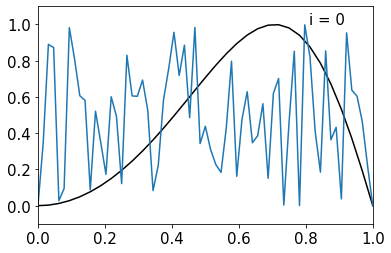

In [10]:
fig = plt.figure()
ax = plt.axes(xlim = (0,1), ylim = (-0.1,1.1))
plt.rcParams.update({'font.size': 15})
time_text = ax.text(0.81, 1, '')
exact, = ax.plot(x,np.sin(np.pi * x **2), color= 'black')
sol, = ax.plot([],[])

N = 65
h = 1/(N-1)
x = np.linspace(0,1,N)
f = 2 * np.pi * np.cos( np.pi * x**2) - 4 * np.pi**2 * x**2 * np.sin( np.pi * x **2)

        
## let us generate a random initial guess that satisfies the boundary conditions u(0) = u(1) = 0
u = np.random.random(N)
u[0] = 0
u[-1] = 0
evolution = RelEvolve(u, f, h, RelSOR)

def get_plot(data_gen, skip):
    def plot(n):
        u = next(data_gen)
        sol.set_data(x, u)
        time_text.set_text('i = {0}'.format(n))
        for _ in range(skip - 1):
            u = next(data_gen)
        return (sol,time_text)
    return plot

plot_func = get_plot(evolution, 1)

ani = anim.FuncAnimation(fig, plot_func, frames = 500, interval = 50, blit = True)

In [11]:
HTML(ani.to_html5_video())